In [1]:
import numpy as np
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as tfs
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 256
CHANNELS = 1
IMAGEY = 28
IMAGEX = 28
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Load dataset

In [3]:
# MNIST Dataset
train_dataset = datasets.MNIST(
    root='./mnist_data/', train=True, transform=tfs.ToTensor(), download=True
)
valid_dataset = datasets.MNIST(
    root='./mnist_data/', train=False, transform=tfs.ToTensor(), download=False
)

# Data Loader (Input Pipeline)
dataloader = {
    'train': DataLoader(
        dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False
    ),
    'valid': DataLoader(
        dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False
    )
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def show_images(faces: np.ndarray, size: Tuple[int, int] = (1, 8)):
    rows, cols = size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for ax, img in zip(axes.flatten(), faces):
        ax.axis('off')
        ax.imshow(img.numpy().transpose(1, 2, 0))

In [5]:
def show_metrics(metrics: Dict[str, List[float]]) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='validation')
    plt.grid()
    plt.legend()
    plt.show()

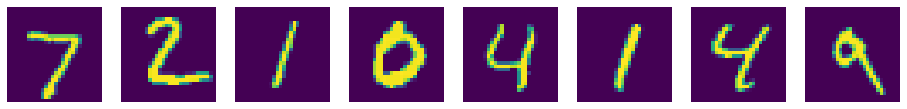

In [6]:
test_imgs, test_labels = next(iter(dataloader['valid']))
show_images(test_imgs[:8])

# VAE Model
Realize the model

In [7]:
HIDDEN_DIM = 16

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=(CHANNELS * IMAGEY * IMAGEX), out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(HIDDEN_DIM * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=HIDDEN_DIM, out_features=128),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=(CHANNELS * IMAGEY * IMAGEX)),
            nn.Sigmoid(),
        )
        
    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, HIDDEN_DIM)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view(-1, CHANNELS, IMAGEY, IMAGEX)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Tried to implement KL-divergence

In [8]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu: torch.Tensor, logsigma: torch.Tensor):
        return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())


class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_divergence = KLDivergenceLoss()
        self.log_likelihood = nn.BCELoss(reduction='sum')

    def forward(self,
        mu: torch.Tensor,
        logsigma: torch.Tensor,
        outputs: torch.Tensor,
        labels: torch.Tensor
    ) -> torch.Tensor:
        return self.kl_divergence(mu, logsigma) + self.log_likelihood(outputs, labels)

Train the model, look at the result

In [9]:
autoencoder_vae = VAE().to(DEVICE)
criterion = VAELoss()
optimizer = torch.optim.Adam(autoencoder_vae.parameters())

In [10]:
def train_model(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 25
) -> Dict[str, List[float]]:
    """Training the model. Returns dictionary of train and validation losses.
    Args:
        model (torch.nn.Module): Neural network
        dataloader (Dict[str, DataLoader]):
            Dictionary with 'train' and 'valid' dataloaders
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        epochs (int): Number of training iterations. Default: 50
    """

    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))
            
            #for inputs, _ in tqdm(dataloader[phase], desc=f'Phase {phase}'):
            for inputs, _ in dataloader[phase]:
                inputs = inputs.to(DEVICE)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    mu, logsigma, reconstruction = model(inputs)
                    loss = criterion(mu, logsigma, reconstruction, inputs.float())
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        mu, logsigma, reconstruction = model(inputs)
                        loss = criterion(mu, logsigma, reconstruction, inputs.float())
                
                loss_accum.append(loss.item())
                #print(loss.item())

            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))

    return losses

In [11]:
losses = train_model(autoencoder_vae, dataloader, criterion, optimizer, epochs=50)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

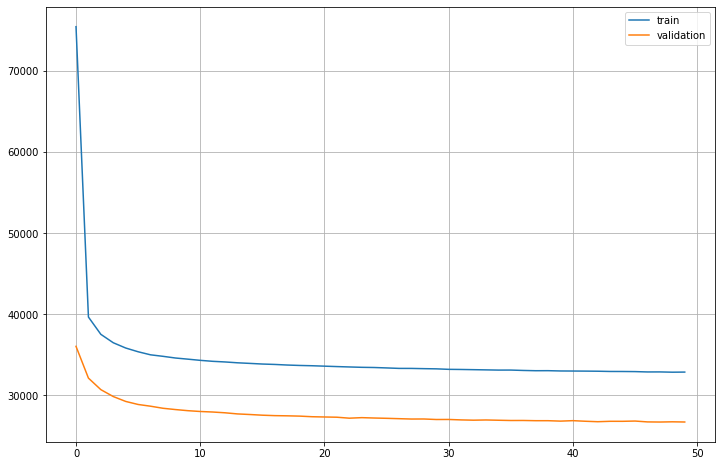

In [12]:
show_metrics(losses)

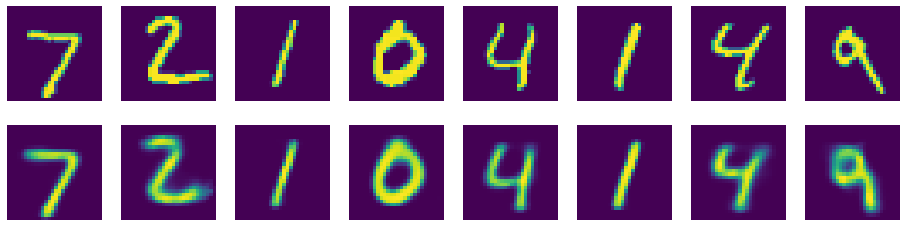

In [13]:
autoencoder_vae.eval()
with torch.no_grad():
    _, _, reconstruction = autoencoder_vae(test_imgs.to(DEVICE))
pairs = torch.cat((test_imgs[:8], reconstruction[:8].cpu()))
show_images(pairs, size=(2, 8))

Let's generate random vectors, run through the decoder, see what happens

  0%|          | 0/235 [00:00<?, ?it/s]

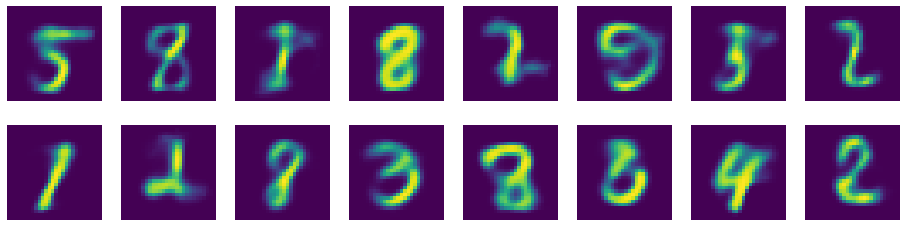

In [14]:
zs = torch.Tensor()
for inputs, _ in tqdm(dataloader['train']):
    inputs = inputs.to(DEVICE)
    with torch.no_grad():
        mu, logsigma = autoencoder_vae.encode(inputs)
        z = autoencoder_vae.gaussian_sampler(mu, logsigma)
        zs = torch.cat((zs, z.cpu()))

mu = zs.mean(dim=0)
std = zs.std(dim=0)

z = torch.FloatTensor([np.random.normal(0, 1, 16) for i in range(16)])
z = z * std + mu

autoencoder_vae.eval()
with torch.no_grad():
    sample = autoencoder_vae.decode(z.to(DEVICE))
sample = sample.cpu().detach()
show_images(sample, size=(2, 8))

# Latent Representation 

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects

x = zs[::10].numpy()
colors = np.array([color for _, color in train_dataset])[::10]

ts = TSNE(random_state=42, verbose=2).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.010s...
[t-SNE] Computed neighbors for 6000 samples in 1.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.965641
[t-SNE] Computed conditional probabilities in 0.268s
[t-SNE] Iteration 50: error = 91.9044266, gradient norm = 0.0006905 (50 iterations in 3.220s)
[t-SNE] Iteration 100: error = 85.9689560, gradient norm = 0.0015051 (50 iterations in 4.243s)
[t-SNE] Iteration 150: error = 85.6197433, gradient norm = 0.0001739 (50 iterations in 3.147s)
[t-SNE] Iteration 200: error = 85.6122055, gradient norm = 0.0001363 (50 iterations in 3.425s)
[t

In [16]:
def latent_presentation(dig, colors):
    palette = np.array(sns.color_palette("hls", 10))
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.scatter(dig[:,0], dig[:,1], c=palette[colors])
    plt.axis('tight')

    for i in range(10):
        labelx, labely = np.mean(dig[colors == i, :], axis=0)
        lbl = ax.text(labelx, labely, str(i), c=palette[i], fontsize=30)
        lbl.set_path_effects([
            PathEffects.Stroke(linewidth=3, foreground="w"),
            PathEffects.Normal()
        ])
    plt.show()

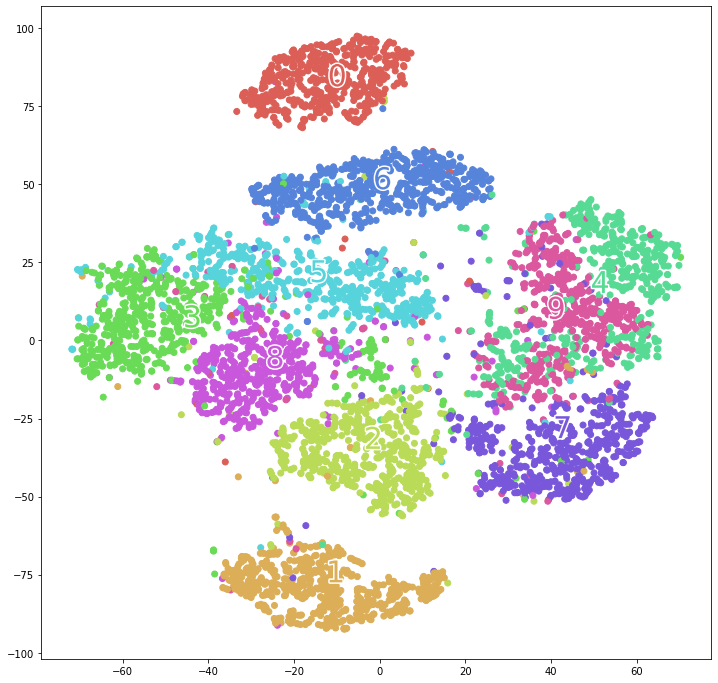

In [17]:
latent_presentation(ts, colors)

Representations of various numbers are quite far apart from each other, except for 4 and 9 (they are very similar). For normal generation, you need to find the distribution of each digit, and not the entire dataset - then the generation results will be better.

# Conditional VAE

In [18]:
HIDDEN_DIM = 16
NUM_CLASSES = 10

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=(CHANNELS * IMAGEY * IMAGEX + NUM_CLASSES),
                out_features=256,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(HIDDEN_DIM * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=(HIDDEN_DIM + NUM_CLASSES),
                out_features=128,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(
                in_features=256,
                out_features=(CHANNELS * IMAGEY * IMAGEX),
            ),
            nn.Sigmoid(),
        )
    
    def add_class_info(self, x, class_num):
        x = self.flatten(x)
        outx = torch.zeros(x.shape[0], x.shape[1] + NUM_CLASSES, dtype=torch.float32)
        outx[:, :(-NUM_CLASSES)] = x
        for i in range(x.shape[0]):
            outx[i, x.shape[1] + class_num[i]] = 1
        outx = outx.to(DEVICE)
        return outx
        
    def encode(self, x, class_num):
        x = self.add_class_info(x, class_num)
        x = self.encoder(x).view(-1, 2, HIDDEN_DIM)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu
    
    def decode(self, z, class_num):
        z = self.add_class_info(z, class_num)
        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view(-1, CHANNELS, IMAGEY, IMAGEX)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, _ = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [19]:
def train_model(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 25
) -> Dict[str, List[float]]:
    """Training the model. Returns dictionary of train and validation losses.
    Args:
        model (torch.nn.Module): Neural network
        dataloader (Dict[str, DataLoader]):
            Dictionary with 'train' and 'valid' dataloaders
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        epochs (int): Number of training iterations. Default: 50
    """

    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))
            
            for inputs, class_num in dataloader[phase]:
                inputs = inputs.to(DEVICE)
                class_num = class_num.to(DEVICE)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    mu, logsigma, reconstruction = model(inputs, class_num)
                    loss = criterion(mu, logsigma, reconstruction, inputs.float())
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        mu, logsigma, reconstruction = model(inputs, class_num)
                        loss = criterion(mu, logsigma, reconstruction, inputs.float())
                
                loss_accum.append(loss.item())

            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))

    return losses

In [20]:
autoencoder_cvae = CVAE().to(DEVICE)
criterion = VAELoss()
optimizer = torch.optim.Adam(autoencoder_cvae.parameters())

In [21]:
losses = train_model(autoencoder_cvae, dataloader, criterion, optimizer, epochs=50)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

I forgot to withdraw the loss, but it is lower than that of VAE, because additional information is involved in the training in the form of a class of numbers, and this allows them to be better separated.

Let's find the representation of the first image (it's 7ka), and transfer its style to the rest of the numbers from 0 to 9

tensor([[0]])
tensor([[1]])
tensor([[2]])
tensor([[3]])
tensor([[4]])
tensor([[5]])
tensor([[6]])
tensor([[7]])
tensor([[8]])
tensor([[9]])


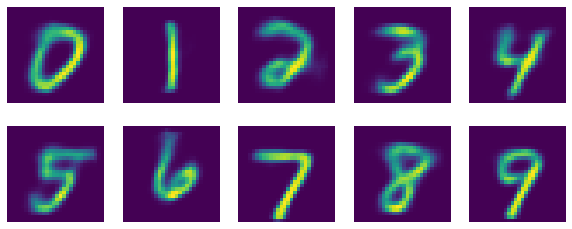

In [22]:
autoencoder_cvae.eval()
with torch.no_grad():
    mu, logsigma, _ = autoencoder_cvae.encode(
        test_imgs.to(DEVICE),
        test_labels.to(DEVICE),
    )
    z = autoencoder_cvae.gaussian_sampler(mu, logsigma)
    test_z = z[0][None,:]
    imgs = torch.Tensor()
    for i in range(NUM_CLASSES):
        test_class = torch.LongTensor([i])[None,:]
        print(test_class)
        reconstruction = autoencoder_cvae.decode(test_z, test_class)
        imgs = torch.cat((imgs, reconstruction.cpu()))
show_images(imgs, size=(2, 5))

  0%|          | 0/235 [00:00<?, ?it/s]

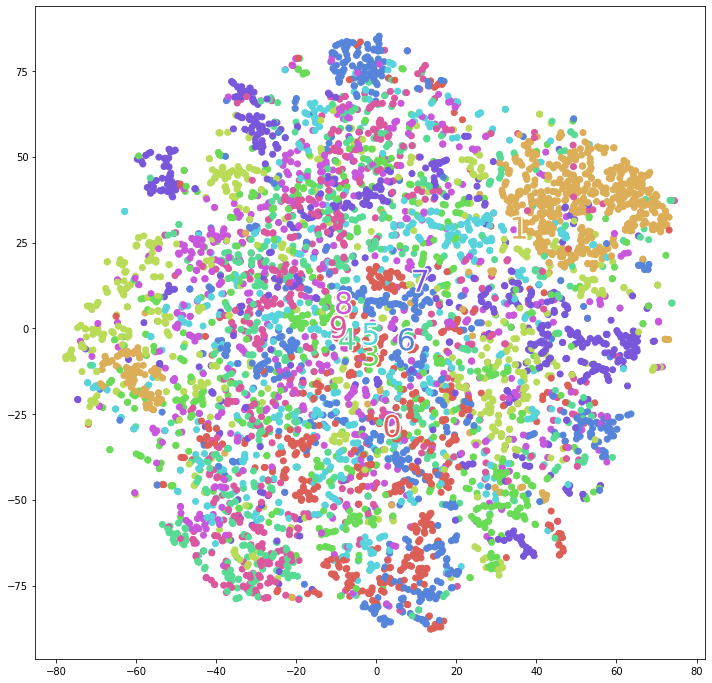

In [23]:
zs = torch.Tensor()
autoencoder_cvae.eval()
for inputs, labels in tqdm(dataloader['train']):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        mu, logsigma, _ = autoencoder_cvae.encode(
            inputs.to(DEVICE),
            labels.to(DEVICE),
        )
        z = autoencoder_cvae.gaussian_sampler(mu, logsigma)
        zs = torch.cat((zs, z.cpu()))
x = zs[::10].numpy()

ts = TSNE(random_state=42, verbose=0).fit_transform(x)
latent_presentation(ts, colors)

The latent representation of CVAE is different from VAE. Here we divide into clusters not the numbers themselves, but their styles, which is why there are so many different small concentrations.